In [ ]:
! pip install datasets rouge

In [ ]:
import time
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from datasets import load_dataset
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

In [ ]:
# Load the dataset
dataset_repo = "neulab/tldr"
train_data = load_dataset(dataset_repo, split="train")
val_data = load_dataset(dataset_repo, split="validation")
test_data = load_dataset(dataset_repo, split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for neulab/tldr contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/neulab/tldr
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
# Combine "nl" and "cmd" with separators to form a list of strings as training data
train_sentences = [f'<start> {data["nl"]} <sep> {data["cmd"]} <end>' for data in train_data]

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)
total_words = len(tokenizer.word_index) + 1

In [ ]:
tokenizer.index_word[10]

'of'

In [ ]:
sep_index = tokenizer.word_index["sep"]

# Create sequences and labels
input_sequences = []
for line in train_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(token_list.index(sep_index)+1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

In [ ]:
input_sequences[:,:-1][1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    1,  134,    6,  385,   10,    4,
       2714,  224,    3, 3256], dtype=int32)

In [ ]:
# Prepare validation sentences in the same way as training sentences
val_sentences = [f'<start> {data["nl"]} <sep> {data["cmd"]} <end>' for data in val_data]

# Create sequences for validation data
val_sequences = []
for line in val_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(token_list.index(sep_index), len(token_list)):
        n_gram_sequence = token_list[:i+1]
        val_sequences.append(n_gram_sequence)

# Pad sequences for validation data
val_sequences = np.array(pad_sequences(val_sequences, maxlen=max_sequence_len, padding='pre'))

# Create predictors and label for validation data
val_predictors, val_label = val_sequences[:,:-1],val_sequences[:,-1]

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(total_words, 256, input_length=max_sequence_len-1))  # Increased embedding dimension
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Using Bidirectional LSTM
model.add(Dropout(0.5))  # Added dropout layer
model.add(Bidirectional(LSTM(32)))  # Using Bidirectional LSTM
model.add(Dropout(0.5))  # Added dropout layer
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
model.summary()

# Define callbacks
filepath = f"results-{int(time.time())}/best_model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 256)           1655040   
                                                                 
 bidirectional (Bidirection  (None, 48, 128)           164352    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 48, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 6465)              4

In [ ]:
# Train the model
history = model.fit(predictors, label, epochs=10,validation_data=(val_predictors, val_label), callbacks=callbacks_list)

Epoch 1/10
1288/1288 [==============================] - 231s 174ms/step - loss: 6.1578 - accuracy: 0.1890 - val_loss: 6.7195 - val_accuracy: 0.2148
Epoch 2/10
1288/1288 [==============================] - 220s 171ms/step - loss: 5.6212 - accuracy: 0.2236 - val_loss: 6.9413 - val_accuracy: 0.2203
Epoch 3/10
1288/1288 [==============================] - 226s 175ms/step - loss: 5.4373 - accuracy: 0.2265 - val_loss: 7.2856 - val_accuracy: 0.2199
Epoch 4/10
1288/1288 [==============================] - 226s 176ms/step - loss: 5.3009 - accuracy: 0.2293 - val_loss: 7.5571 - val_accuracy: 0.2147
Epoch 5/10
1288/1288 [==============================] - 227s 176ms/step - loss: 5.1652 - accuracy: 0.2381 - val_loss: 7.7261 - val_accuracy: 0.2159
Epoch 6/10
1288/1288 [==============================] - 222s 173ms/step - loss: 5.0492 - accuracy: 0.2467 - val_loss: 7.9833 - val_accuracy: 0.2140
Epoch 7/10
1288/1288 [==============================] - 218s 169ms/step - loss: 4.9332 - accuracy: 0.2548 - val_

In [ ]:
# Function for generating text
def generate_text(seed_text, next_words, model, max_sequence_len):
    predicted_command = ""
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted = np.argmax(predicted_probs, axis=-1)

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break

        if output_word == "end":
            break

        seed_text += " " + output_word
        predicted_command += " " + output_word

    return predicted_command

# Predict command for "set the label of a fat32 partition"
input_text = "<start> display a message with inverted colors <sep>"
predicted_command = generate_text(input_text, 10, model, max_sequence_len)  # Predict next 10 words
print(f'Predicted command: {predicted_command}')


Predicted command:  git install branch name


In [ ]:
# Prepare test sentences in the same way as training sentences
test_sentences = [f'<start> {data["nl"]} <sep>' for data in test_data]
actual_commands = [data["cmd"] for data in test_data]

predicted_commands = []
for sentence in test_sentences:
    predicted_commands.append(generate_text(input_text, 10, model, max_sequence_len))

# Calculate BLEU scores
bleu_scores = [sentence_bleu([actual.split()], predicted.split()) for predicted, actual in zip(predicted_commands, actual_commands)]
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print(f'Average BLEU score: {average_bleu_score}')

# Calculate ROUGE scores
rouge = Rouge()
rouge_scores = [rouge.get_scores(predicted, actual)[0]['rouge-l']['f'] for predicted, actual in zip(predicted_commands, actual_commands)]
average_rouge_score = sum(rouge_scores) / len(rouge_scores)
print(f'Average ROUGE-L score: {average_rouge_score}')


Text(0.5, 1.0, 'Accuracy over epochs')

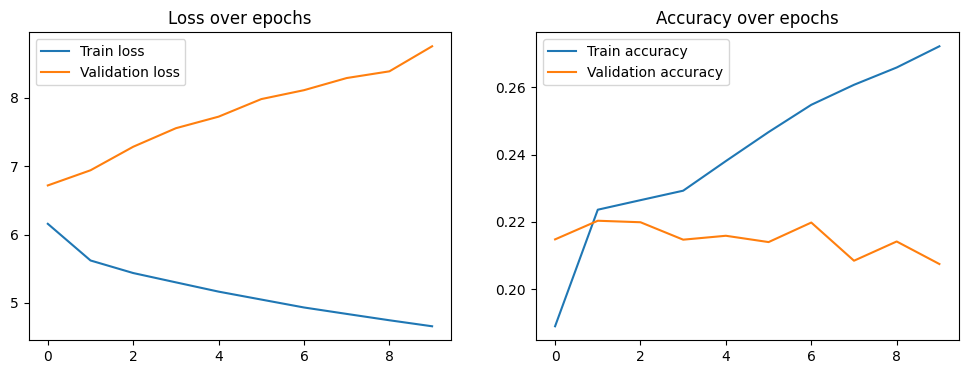

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy over epochs')

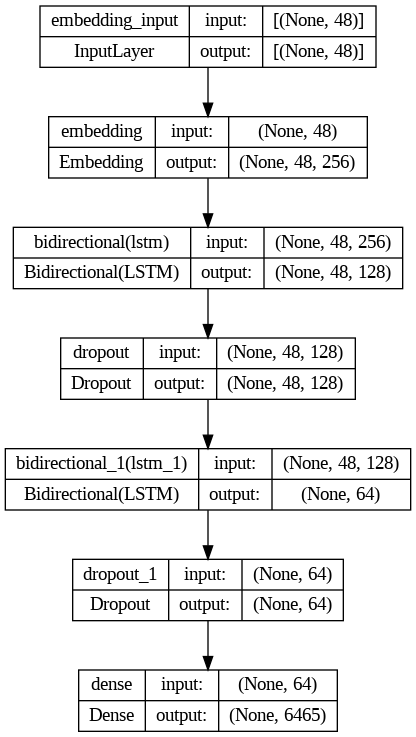

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model1.png', show_shapes=True, show_layer_names=True)

In [16]:
model = Sequential()
model.add(Embedding(total_words, 256, input_length=max_sequence_len-1))  # Increased embedding dimension
model.add(GRU(64, return_sequences=True))  # Using Bidirectional LSTM
model.add(Dropout(0.5))  # Added dropout layer
model.add(GRU(32))  # Using Bidirectional LSTM
model.add(Dropout(0.5))  # Added dropout layer
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 48, 256)           1655040   
                                                                 
 gru_2 (GRU)                 (None, 48, 64)            61824     
                                                                 
 dropout_3 (Dropout)         (None, 48, 64)            0         
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 6465)              213345    
                                                                 
Total params: 1939617 (7.40 MB)
Trainable params: 1939

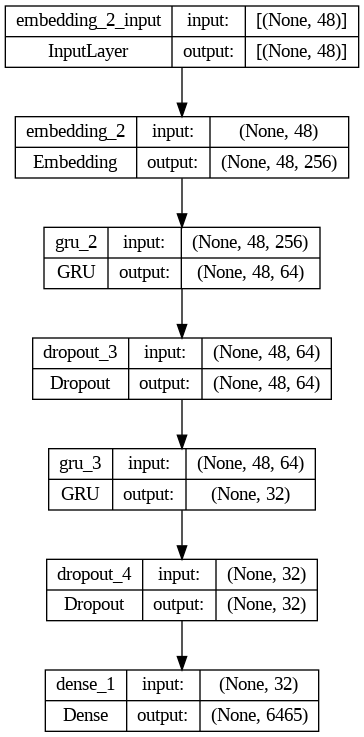

In [17]:
plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=True)